In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Введение

#### Для построения геомеханической модели необходимы исходные каротажные данные, которые записываются в стволе скважины. 
#### На этих данных базируется расчет упруго-прочностных свойств и дальнейшее получение напряженно-деформированного состояния горного массива.
#### Минимально необходимым комплексом каротажных данных является: акустические данные (продольная и поперечная волна в виде скорости или медленности), плотностной каротаж и гамма-каротаж. 

## Проблематика

#### Отсутствие записи поперечной волны на большинстве скважин из-за дорогостоящих исследований.
#### В большинстве скважин при этом имеется записть продольной волны и плотности, которые имеют высокую корреляцию с поперечной волной.
#### Геомеханики вручную строят линейную регрессию на имеющихся данных и восстаналивают недостающий каротаж.
#### Необходимо оптимизировать этот процесс и сократить время выполнения однообразной задачи восстановления.

## Цель проекта: Обучить модель восстановливать поперечную волну на основе имеющихся данных по поперечной волне и плотности

#### Примечание: 
#### Две модели с возможностью инкрементального обучения: 
#### 1. Восстановление от продольной волны и плотности
#### 2. Восстановление от продольной волны при отсутствии каротажа плотности

## 1. Обзор данных

#### Нам представлены данные для некоторого региона, где нужно реализовать восстановление поперечной волны на основе каротажей плотности и продольной волны для новых скважин.
#### В наличии 5 скважин, 4 из которых буду представлять тренировочный набор данных, а 1 скважина будет являться тестовой для предсказания модели.
#### Скважины имеют 4 столбца:
#### MD - глубина замера
#### DTCO - замер медленности продольной волны
#### DTSM - замер медленности поперечной волны (целевой признак)
#### RHOB - замер плотности

In [10]:
region_1 = [
    "region_1_well_1.csv",
    "region_1_well_2.csv",
    "region_1_well_3.csv",
    "region_1_well_4.csv"
]
# Объединеные скважин в один тренировочный набор данных
df = [pd.read_csv(file) for file in region_1]
train = pd.concat(df, ignore_index=True)

train.to_csv("train_region_1.csv", index=False)

# Создение тестового датасета
test = pd.read_csv('region_1_well_5_test.csv')

In [11]:
train.head(5)

,MD,DTCO,DTSM,RHOB
0,m,us/m,us/m,g/cm3
1,MD,DT_full,DTS_full,RHOB_full_1
2,0,-999.25,-999.25,-999.25
3,0.1524,-999.25,-999.25,-999.25
4,0.3048,-999.25,-999.25,-999.25


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157492 entries, 0 to 157491
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   MD      157492 non-null  object
 1   DTCO    157492 non-null  object
 2   DTSM    157492 non-null  object
 3   RHOB    118119 non-null  object
dtypes: object(4)
memory usage: 4.8+ MB


In [13]:
print(f'Количество пропущенных значений:\n{train.isnull().sum()}')

Количество пропущенных значений:
MD          0
DTCO        0
DTSM        0
RHOB    39373
dtype: int64


#### Первые две строки следует удалить - это единицы измерения и названия каротажей, выгруженные из рабочих проектов.
#### Так как мы соединили несколько файлов, такие же строки лежат еще внутри датафрейма от 3 следующих скважин.
#### Избавимся от них при переходе к числовому типу, вставив NaN.

In [15]:
train = train.apply(pd.to_numeric, errors='coerce')
test = test.apply(pd.to_numeric, errors='coerce')

In [16]:
print(f'Количество пропущенных значений:\n{train.isnull().sum()}')

Количество пропущенных значений:
MD          8
DTCO        8
DTSM        8
RHOB    39379
dtype: int64


#### Удалим NaN, которые остались от названий единиц измеренеия и каротажей.

In [18]:
train = train.dropna(subset=['DTCO'])

In [19]:
print(f'Количество пропущенных значений:\n{train.isnull().sum()}')

Количество пропущенных значений:
MD          0
DTCO        0
DTSM        0
RHOB    39371
dtype: int64


#### Значения -999.25 означают отсутствие каротажа на данной глубине, их следует удалить.

In [21]:
train = train.loc[~(train == -999.25).any(axis=1)]
test = test.loc[~(test == -999.25).any(axis=1)]

#### Теперь можем удалить столбец глубины, так как в дальнейшем он нам не понадобится.

In [23]:
train = train.drop("MD", axis=1) 
test = test.drop("MD", axis=1) 

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30344 entries, 9317 to 145354
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DTCO    30344 non-null  float64
 1   DTSM    30344 non-null  float64
 2   RHOB    17193 non-null  float64
dtypes: float64(3)
memory usage: 948.2 KB


#### Видим пропущенные значения в каротаже плотности. Каротаж плотности, как и каротаж продольной волны, обладает высокой корреляцией с поперечной волной.  
#### Мы не можем заполнить средним или медианой, так как оба признака необходимы для наиболее корректного восстановления DTSM.
#### Предлагается обучить две модели: восстановление DTSM только от DTCO и восстановление DTSM от DTCO и RHOB (вторая модель должна демонстрировать лучший результат).
#### В таком случае в дальнейшем человек сможет восстаналивать каротаж как при наличии одного каротажа, так и при наличии обоих каротажей. 

#### Разделим данные на два датасета 

In [27]:
train_dtco_rhob = train.dropna(subset=["RHOB"]) # Датасет с плотностью
train_dtco = train.drop("RHOB", axis=1) # Датасет без плотности

test_dtco_rhob = test.dropna(subset=["RHOB"])
test_dtco = test.drop("RHOB", axis=1)

## 2. Разведочный анализ данных

In [29]:
train.describe()

,DTCO,DTSM,RHOB
count,30344.000000,30344.000000,17193.000000
mean,272.267394,475.144836,2.415136
std,41.023597,72.236242,0.152927
min,104.701464,268.781760,0.977152
25%,240.801222,418.778403,2.316480
50%,260.786724,455.381197,2.437084
75%,302.463885,535.208185,2.518656
max,463.718792,775.209616,2.849200


Text(0, 0.5, 'Частота')

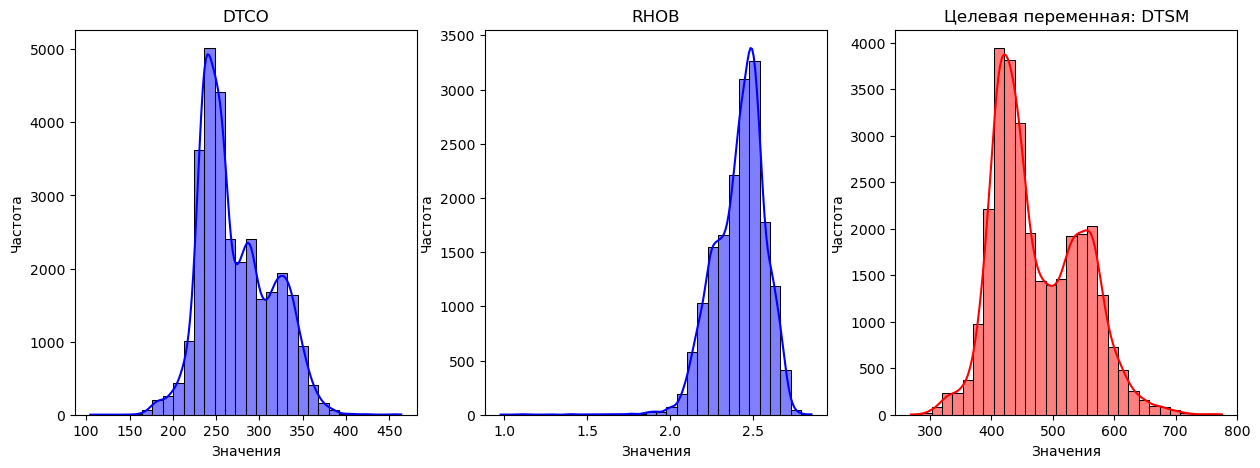

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(train['DTCO'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('DTCO')
axes[0].set_xlabel('Значения')
axes[0].set_ylabel('Частота')

sns.histplot(train['RHOB'], bins=30, kde=True, color='blue', ax=axes[1])
axes[1].set_title('RHOB')
axes[1].set_xlabel('Значения')
axes[1].set_ylabel('Частота')

sns.histplot(train['DTSM'], bins=30, kde=True, color='red', ax=axes[2])
axes[2].set_title('Целевая переменная: DTSM')
axes[2].set_xlabel('Значения')
axes[2].set_ylabel('Частота')

#### DTCO: Данные смещены влево с хвостом вправо. Проглядывается бимодальное распределение как и в случае с DTSM. Наблюдаются выбросы.
#### RHOB: Данные смещены вправо с хвостом влево. Узкое распределение значений, что характерно для плотностного каротажа. Плотность пород варьируется в небольших пределах. Наблюдаются выбросы.
#### DTSM: Данные имеют бимодальное распределение, что может указывать на наличие подгрупп разных пород. Наблюдаются выбросы.

Text(0, 0.5, 'Значения')

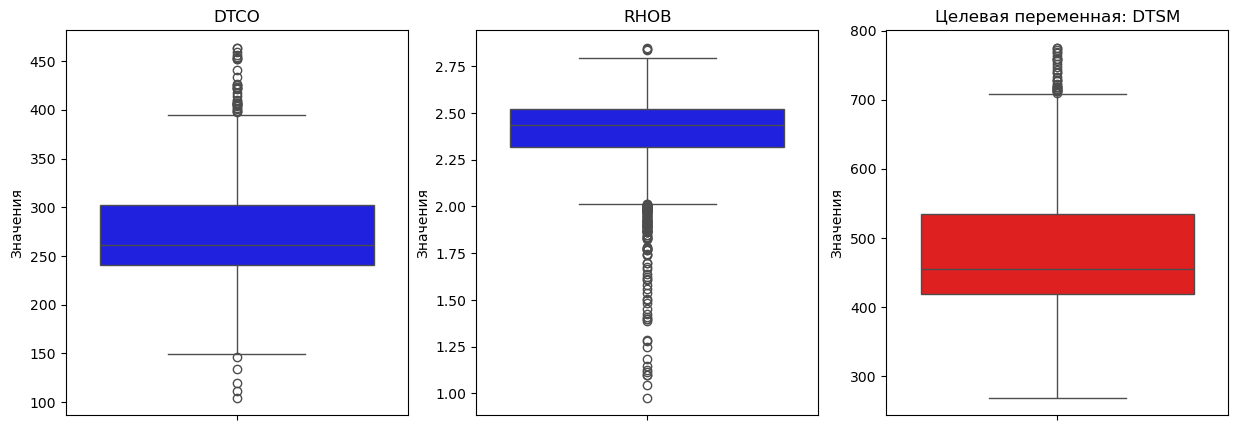

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Строим ящики с усами для каждого столбца
sns.boxplot(y=train['DTCO'], ax=axes[0], color='blue')
axes[0].set_title('DTCO')
axes[0].set_ylabel('Значения')

sns.boxplot(y=train['RHOB'], ax=axes[1], color='blue')
axes[1].set_title('RHOB')
axes[1].set_ylabel('Значения')

sns.boxplot(y=train['DTSM'], ax=axes[2], color='red')
axes[2].set_title('Целевая переменная: DTSM')
axes[2].set_ylabel('Значения')

In [33]:
train_dtco_rhob.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17193 entries, 9317 to 145354
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DTCO    17193 non-null  float64
 1   DTSM    17193 non-null  float64
 2   RHOB    17193 non-null  float64
dtypes: float64(3)
memory usage: 537.3 KB


#### Видны выбросы в каротажах. Возможные причины: обрушения ствола скважины в некоторых участках или некорректная запись приробов на начало и конец секций колонн в скважине.
#### Однако, стоит учитывать, что физические свойства пород изменяются в широких пределах.
#### Например, плотность обычно изменяется от 1.8 до 3, со скоростью дела обстоят сложнее, границы могут зависеть не только от породы, но и от прибора. 
#### DTCO ниже 150 также выглядит нефизично
#### Удалим некоторые выбросы, в которых мы уверены

In [35]:
train_dtco_rhob = train_dtco_rhob[train_dtco_rhob['RHOB'] >= 1.8]
test_dtco_rhob = test_dtco_rhob[test_dtco_rhob['RHOB'] >= 1.8]

train_dtco_rhob = train_dtco_rhob[train_dtco_rhob['DTCO'] >= 150]
test_dtco_rhob = test_dtco_rhob[test_dtco_rhob['DTCO'] >= 150]

In [36]:
train_dtco_rhob.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17150 entries, 9317 to 145354
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DTCO    17150 non-null  float64
 1   DTSM    17150 non-null  float64
 2   RHOB    17150 non-null  float64
dtypes: float64(3)
memory usage: 535.9 KB


Text(0, 0.5, 'Значения')

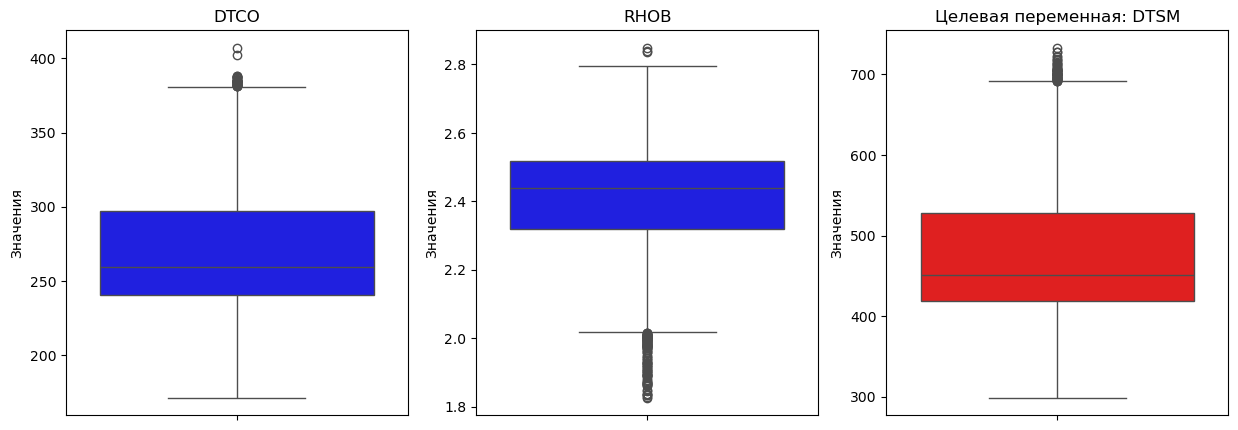

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(y=train_dtco_rhob['DTCO'], ax=axes[0], color='blue')
axes[0].set_title('DTCO')
axes[0].set_ylabel('Значения')

sns.boxplot(y=train_dtco_rhob['RHOB'], ax=axes[1], color='blue')
axes[1].set_title('RHOB')
axes[1].set_ylabel('Значения')

sns.boxplot(y=train_dtco_rhob['DTSM'], ax=axes[2], color='red')
axes[2].set_title('Целевая переменная: DTSM')
axes[2].set_ylabel('Значения')

#### Перейдем к анализу корреляций

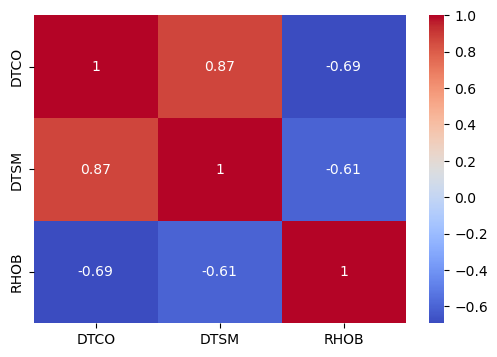

In [39]:
corr_matrix = train_dtco_rhob.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Как и говорилось ранее, каротажи обладают высокой корреляционной связью

<Figure size 1000x600 with 0 Axes>

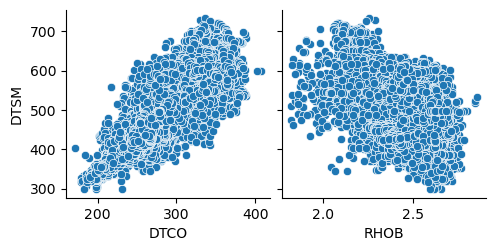

In [41]:
plt.figure(figsize=(10, 6))
sns.pairplot(train_dtco_rhob, x_vars=['DTCO', 'RHOB'], y_vars='DTSM')
plt.show()

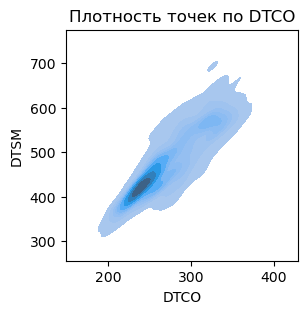

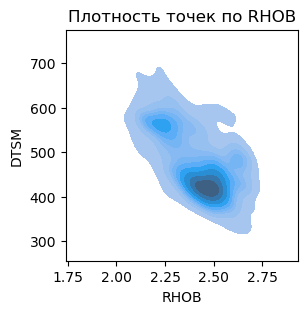

In [42]:
plt.figure(figsize=(3, 3))
sns.kdeplot(data=train_dtco_rhob, x='DTCO', y='DTSM', fill=True)
plt.title('Плотность точек по DTCO')
plt.show()

plt.figure(figsize=(3, 3))
sns.kdeplot(data=train_dtco_rhob, x='RHOB', y='DTSM', fill=True)
plt.title('Плотность точек по RHOB')
plt.show()

#### DTSM от DTCO: корреляция 0.87, при этом видны небольшие выбросы DTCO. Кластеры не выделяются.
#### DTSM от RHOB: корреляция -0.61, разброс значений более заметен, наблюдаются выбросы. Кластеры не выделяются.
#### На данном этапе корреляция выглядит удовлетворительной, чтобы идти дальше.

## 3. Обучение модели

#### Нам необходимо выбрать модель с возможностью инкремантального обучения, чтобы в последствии люди смогли догружать дополнительные данные. 
#### Это пригодится, если, например, рядом есть две скважины, но на одной из них нет каротажа, то данные с ближайшей будут наиболее подходящие для восстановления.
#### Рассмотрим вариант с SGDRegressor и LightGBM, которые поддерживают метод partial_fit 

In [46]:
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression

state = 11

### Модель 1. Восстановление от DTCO и RHOB

In [48]:
target_1 = train_dtco_rhob['DTSM']
features_1 = train_dtco_rhob.drop('DTSM', axis = 1)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state = state)

#### Для проверки поддержки дообучения разделим тренировочный набор данных на два датасета

In [50]:
# f1, f2, t1, t2 = train_test_split(
#     features_train_1, target_train_1, test_size=0.50, random_state = state)

In [51]:
# model = SGDRegressor(random_state = state)

# model.partial_fit(f1, t1)

# target_pred = model.predict(features_valid_1)
# print("MSE:", mean_squared_error(target_valid_1, target_pred))

# # Дообучение на новых данных
# model.partial_fit(f2, t2)

# # Повторное предсказание и оценка
# target_pred = model.predict(features_valid_1)
# print("MSE после дообучения:", mean_squared_error(target_valid_1, target_pred))

#### Идем дальше

In [53]:
scaler1 = StandardScaler()
features_train_1 = scaler1.fit_transform(features_train_1)
features_valid_1 = scaler1.transform(features_valid_1)

model_1 = SGDRegressor(random_state = state)

model_1.partial_fit(features_train_1, target_train_1)

target_pred = model_1.predict(features_valid_1)
print("R2:", r2_score(target_valid_1, target_pred))
print("RMSE:", root_mean_squared_error(target_valid_1, target_pred))

R2: 0.7559639998445103
RMSE: 35.22541925633265


#### Неплохие результаты для baseline. Поищем гиперпараметры

In [55]:
# Инициализация модели
model = SGDRegressor()

# Параметры для подбора
param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': [0.01, 0.1, 0.5],
    'max_iter': [1000, 2000, 5000]
}

# Создание GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=5,
    n_jobs=-1
)
# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2')

# Обучение модели
grid_search.fit(features_train_1, target_train_1)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'alpha': 0.01, 'eta0': 0.5, 'learning_rate': 'optimal', 'max_iter': 2000, 'penalty': 'l1'}


In [56]:
model = SGDRegressor(alpha = 0.01, eta0 = 0.01, learning_rate = 'optimal', max_iter= 5000, penalty = 'l1', random_state = state)

model.partial_fit(features_train_1, target_train_1)

target_pred = model.predict(features_valid_1)
print("R2:", r2_score(target_valid_1, target_pred))
print("RMSE:", root_mean_squared_error(target_valid_1, target_pred))

R2: 0.7547650799492418
RMSE: 35.311842391045865


#### Поиск гиперпараметров не дал положительных результатов, что скорее всего связано с простотой данных, с их небольшим количеством и различным шумом.
#### Проверим, какой результат на обычно линейной регрессии

In [58]:
model = LinearRegression()

# Обучение модели
model.fit(features_train_1, target_train_1)

# Предсказание на тестовых данных
y_pred = model.predict(features_valid_1)

# Оценка качества модели
rmse = root_mean_squared_error(target_valid_1, target_pred)
r2 = r2_score(target_valid_1, target_pred)

print("MSE:", rmse)
print("R²:", r2)

MSE: 35.311842391045865
R²: 0.7547650799492418


#### На наших данных мы далеко не уйдем в поиске наилучшей модели, так как данные слишком просты и просто обладают линейной корреляцией с целевым признаком, которую нам не улучшить, только если вернутся к обработке данных.
#### Скорее всего у нас остались вылетающие или неправильные значения, но мы не можем найти их без дополнительной информации. 
#### Так что будем использовать SGDRegressor без подбора гиперпараметров.
#### Но для начала проверим еще LightGBM

In [60]:
model = LGBMRegressor(random_state = state)

# Обучение модели
model.fit(features_train_1, target_train_1)

# Предсказание на тестовых данных
y_pred = model.predict(features_valid_1)

# Оценка качества модели
rmse = root_mean_squared_error(target_valid_1, target_pred)
r2 = r2_score(target_valid_1, target_pred)

print("MSE:", rmse)
print("R²:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12862, number of used features: 2
[LightGBM] [Info] Start training from score 472.315842
MSE: 35.311842391045865
R²: 0.7547650799492418


#### Вывод: наши данные слишком простые и все модели предсказывают примерно один результат. Логично, учитывая, что у нас всего два параметра с простой линейной зависимостью.
#### Вспомним, что линейная зависимость от DTCO лучше, чем от RHOB. Возможно, плотность дает лишний шум и зависимость только от DTCO будет лучше?
#### Проверим.

### Модель 2. Восстановление от DTCO

In [63]:
target_2 = train_dtco['DTSM']
features_2 = train_dtco.drop('DTSM', axis = 1)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state = state)

In [64]:
scaler2 = StandardScaler()
features_train_2 = scaler2.fit_transform(features_train_2)
features_valid_2 = scaler2.transform(features_valid_2)

model_2 = SGDRegressor(random_state = state)

model_2.partial_fit(features_train_2, target_train_2)

target_pred = model_2.predict(features_valid_2)
print("R2:", r2_score(target_valid_2, target_pred))
print("RMSE:", root_mean_squared_error(target_valid_2, target_pred))

R2: 0.7265155716219773
RMSE: 37.98093970542146


#### Интересно, гипотеза не потвердилась, несмотря на более сильный разброс значений по плотности, она дает более хороший результат в сочетании.
#### Изначальная цель разделение модели на две нашла свое обоснование. При использовании обоих каротажей для восстановления результат лучше. Но, при отсутствии плотности можно тоже восстановить поперечную волну, что даст неплохой результат.
#### Вынесем итоговые результаты.

In [66]:
target_pred = model_1.predict(features_valid_1)
print('Результаты 1 модели на тренировочном наборе:')
print("R2:", r2_score(target_valid_1, target_pred))
print("RMSE:", root_mean_squared_error(target_valid_1, target_pred), '\n')

target_pred = model_2.predict(features_valid_2)
print('Результаты 2 модели на тренировочном наборе:')
print("R2:", r2_score(target_valid_2, target_pred))
print("RMSE:", root_mean_squared_error(target_valid_2, target_pred))

Результаты 1 модели на тренировочном наборе:
R2: 0.7559639998445103
RMSE: 35.22541925633265 

Результаты 2 модели на тренировочном наборе:
R2: 0.7265155716219773
RMSE: 37.98093970542146


## 4. Предсказание на тестовой выборке

In [123]:
target_t = test_dtco_rhob['DTSM']
features_t1 = test_dtco_rhob.drop('DTSM', axis = 1)
features_t2 = test_dtco_rhob.drop(['DTSM', 'RHOB'], axis = 1)

In [125]:
features_t1 = scaler1.transform(features_t1)
features_t2 = scaler2.transform(features_t2)

target_pred = model_1.predict(features_t1)
print('Результаты 1 модели на тестовом наборе:')
print("R2:", r2_score(target_t, target_pred))
print("RMSE:", root_mean_squared_error(target_t, target_pred), '\n')

target_pred = model_2.predict(features_t2)
print('Результаты 2 модели на тестовом наборе:')
print("R2:", r2_score(target_t, target_pred))
print("RMSE:", root_mean_squared_error(target_t, target_pred))

Результаты 1 модели на тестовом наборе:
R2: 0.7473565724869905
RMSE: 22.762294798508364 

Результаты 2 модели на тестовом наборе:
R2: 0.7478110091779475
RMSE: 22.741814001251758


#### Результаты предсказания дали хороший результат, модель не переобучена.
#### Выгрузим наши модели.

In [119]:
import joblib

joblib.dump(model_1, 'model_1.pkl')
joblib.dump(model_2, 'model_2.pkl')

['model_2.pkl']